## Strategy based on EPS surprise 

This signal plays the sign of the difference between actual eps and concensus estimate, it's then mangified by the value of the actual EPS itself

Signal is cross sectionnaly ranked and time series ranked for each stock

Stocks with positive (negative) eps surprise compared to their last years are long (short)

In [24]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
master = DataMaster()
from utils.func import center
from quantstats.stats import sharpe
import matplotlib.pyplot as plt

In [25]:
market_data = pd.read_parquet('data/US/test_mkt_data.pq')
balance_sheet = pd.read_parquet('data/US/test_balance_sheet.pq')
earnings = pd.read_parquet('data/US/test_earnings.pq')
income_statement = pd.read_parquet('data/US/test_income_statement.pq')
cash_flow = pd.read_parquet('data/US/test_cash_flow.pq')
GICS = pd.read_parquet('data/US/test_GICS.pq')
P = pd.read_parquet('data/US/test_universe_table.pq')
P.index.names = ['Date']
R = market_data['close'].unstack().reindex_like(P).pct_change()
market_data.dropna().sample(5)

C:\Users\marti\AppData\Local\Temp\ipykernel_67384\3031020825.py:9: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  R = market_data['close'].unstack().reindex_like(P).pct_change()


,,datetime,open,high,low,close,adj_close,volume,MktCap
Date,Ticker,,,,,,,,
2023-08-02,LRCX,2023-08-02,705.20,707.250,683.60,685.88,681.9539,1498483,3.010840e+12
2022-02-08,VNT,2022-02-08,26.81,27.490,26.81,27.42,27.2072,1640400,2.853128e+12
2022-03-15,MAA,2022-03-15,207.35,207.610,203.40,205.58,191.6602,640296,2.530982e+12
2022-01-04,DRI,2022-01-04,150.67,151.880,149.43,151.60,140.3356,1288037,2.935286e+12
2020-04-21,LYB,2020-04-21,46.15,47.215,44.33,46.63,36.4941,4221653,1.163205e+12


In [26]:

earnings = earnings[~earnings.index.duplicated(keep='first')]
earnings = earnings[earnings['epsActual'].notna()]


In [27]:
earnings.xs('A',level=1).tail(4)
### accurate but small differences with https://www.nasdaq.com/market-activity/stocks/a/earnings

#more generally we remark almost of all the time correct report date, but we're  still data source dependent

,reportDate,date,beforeAfterMarket,currency,epsActual,epsEstimate,epsDifference,surprisePercent
Date,,,,,,,,
2023-04-30,2023-05-23,2023-04-30,AfterMarket,USD,1.27,1.26,0.01,0.7937
2023-07-31,2023-08-15,2023-07-31,AfterMarket,USD,1.43,1.36,0.07,5.1471
2023-10-31,2023-11-20,2023-10-31,AfterMarket,USD,1.38,1.34,0.04,2.9851
2024-01-31,2024-02-27,2024-01-31,AfterMarket,USD,1.29,1.22,0.07,5.7377


In [28]:
earnings.xs('UNH',level=1).tail(4)
### accurate but small differences with https://www.nasdaq.com/market-activity/stocks/unh/earnings
#more generally we remark almost of all the time correct report date, but we're  still data source dependent

,reportDate,date,beforeAfterMarket,currency,epsActual,epsEstimate,epsDifference,surprisePercent
Date,,,,,,,,
2023-03-31,2023-04-14,2023-03-31,BeforeMarket,None,6.26,6.13,0.13,2.1207
2023-06-30,2023-07-14,2023-06-30,BeforeMarket,None,6.14,5.99,0.15,2.5042
2023-09-30,2023-10-13,2023-09-30,BeforeMarket,None,6.56,6.32,0.24,3.7975
2023-12-31,2024-01-12,2023-12-31,BeforeMarket,None,6.16,5.98,0.18,3.0100


In [63]:
eps_actual = earnings['epsActual'].unstack().reindex_like(P).ffill().astype(float)
eps_estimate = earnings['epsEstimate'].unstack().reindex_like(P).ffill().astype(float)
eps_suprise  = (eps_actual * np.sign((eps_actual - eps_estimate))).reindex_like(P).ffill()[P]


In [81]:
signal = eps_suprise[P]
signal = signal[P].rolling(126,min_periods=20).rank(pct=True,ascending=True).clip(0.01,0.99)
signal = signal[P].rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)

C:\Users\marti\AppData\Local\Temp\ipykernel_67384\788336711.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  signal = signal[P].groupby(GICS['gicsect'],axis=1).apply(center)


Sharpe                2.1
Daily turnover (%)    4.5
biais (bp)            1.9
dtype: float64

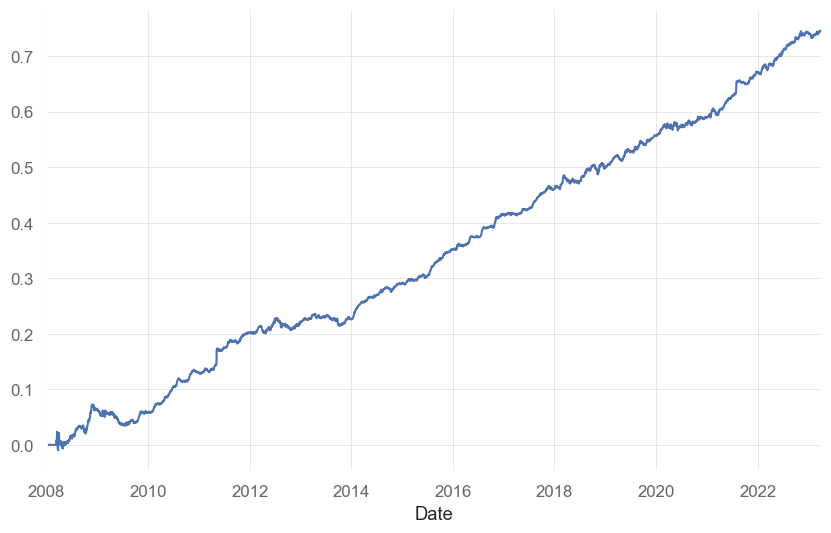

In [82]:
signal = signal[P].groupby(GICS['gicsect'],axis=1).apply(center)
signal = signal[P].div(signal[P].abs().sum(1),0)

PNL = (signal[P].shift(5)*R).sum(1).dropna()
sr = sharpe(PNL)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
PNL.cumsum().plot()
pd.Series({'Sharpe':sr,'Daily turnover (%)':turnover *100,'biais (bp)':PNL.mean()*1e4}).round(1)

<Axes: xlabel='Date'>

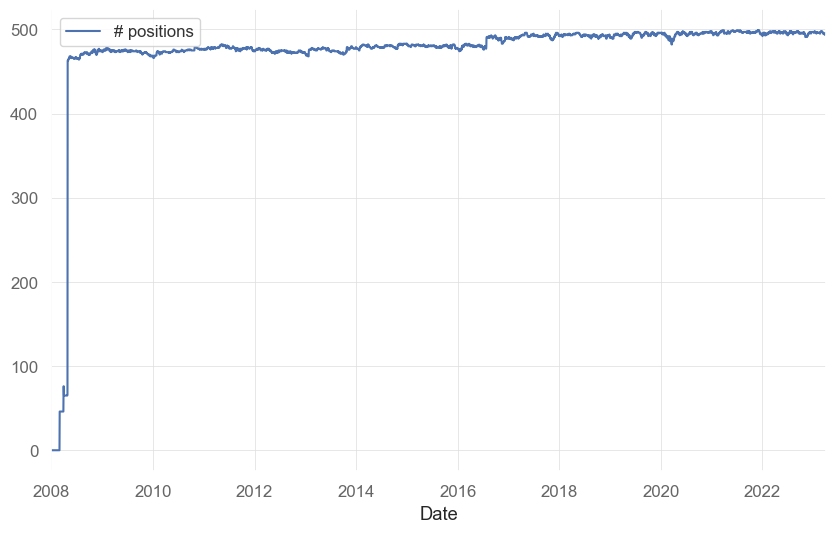

In [83]:
signal.count(1).plot(label ='# positions',legend=True)

<Axes: xlabel='Date'>

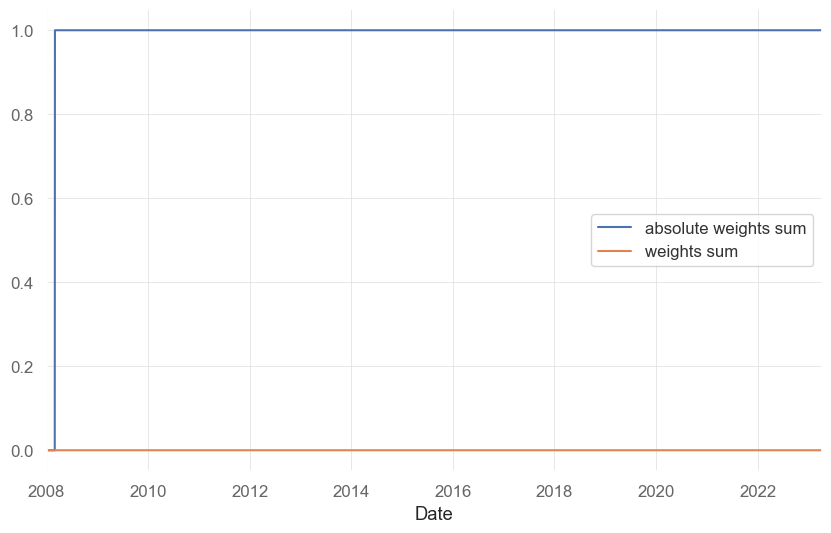

In [79]:
signal.abs().sum(1).plot(label = 'absolute weights sum',legend=True)
signal.sum(1).plot(label='weights sum',legend=True)

In [10]:
import quantstats as qs
SP500 = qs.utils.download_returns('SPY')

# report with fancy (and some unuseful) stats
qs.reports.html(PNL, "SPY",title = 'Strategy EPS Suprise')

c:\Users\marti\AppData\Local\Programs\Python\Python39\lib\site-packages\quantstats\stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)
c:\Users\marti\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


In [13]:
PNL.to_csv('data/US/strat_eps_surprise_pnl.csv')